In [115]:
import numpy as np
from tqdm import tqdm
import gym
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
env = gym.make('Taxi-v3')
num_actions = env.action_space
num_obs = env.observation_space
R, G, B, Y = env.unwrapped.locs
R, G, B, Y = list(R), list(G), list(B), list(Y)
env.reset()


(143, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})

In [117]:
def get_state(state):
    row, col, pass_id, dest_id = env.unwrapped.decode(state)
    state = np.asarray([row,col,pass_id,dest_id])
    return state

#encoding a 5x5 matrix as a 25x1 vector
def encode(pose):
    [row,col] = pose
    state_num = row * 5 + col
    return state_num

def decode(state_num):
    row = state_num // 5
    col = state_num % 5
    return row, col

print(R,G,B,Y)

[0, 0] [0, 4] [4, 0] [4, 3]


In [118]:
curr_state = get_state(env.s)
print("Taxi at",curr_state)
next_state, reward, done, _, _ = env.step(4)
row, col, pass_id, dest_id = env.unwrapped.decode(next_state)

Taxi at [1 2 0 3]


In [119]:
def choose_action(state,qs,eps):
    #print(np.shape(q))
    length = np.shape(qs)[1]
    if not qs[state].any():
        return random.randint(0,length-1)
    action = np.argmax(qs[state])
    
    if np.random.rand() < eps:
        action = np.random.randint(0,length-1)
        return action
    return action

row, col, pass_id, dest_id = env.unwrapped.decode(0)
print(row, col, pass_id, dest_id)
row, col, pass_id, dest_id = env.unwrapped.decode(40)
print(row, col, pass_id, dest_id)
row, col, pass_id, dest_id = env.unwrapped.decode(2)
print(row, col, pass_id, dest_id)
row, col, pass_id, dest_id = env.unwrapped.decode(3)
print(row, col, pass_id, dest_id) 
row, col, pass_id, dest_id = env.unwrapped.decode(4)
print(row, col, pass_id, dest_id) 
row, col, pass_id, dest_id = env.unwrapped.decode(5)
print(row, col, pass_id, dest_id) 
row, col, pass_id, dest_id = env.unwrapped.decode(120)
print(row, col, pass_id, dest_id)           

0 0 0 0
0 2 0 0
0 0 0 2
0 0 0 3
0 0 1 0
0 0 1 1
1 1 0 0


In [120]:
def Red(q_r,state,eps):
    optdone = False
    optact = choose_action(state,q_r,eps)
    state = decode(state)
    if state[0] == R[0] and state[1] == R[1]:
        optdone = True
    return optact,optdone

def Green(q_g,state,eps):
    optdone = False
    optact = choose_action(state,q_g,eps)
    state = decode(state)
    if state[0] == G[0] and state[1] == G[1]:
        optdone = True
    return optact,optdone
    
def Yellow(q_y,state,eps):
    optdone = False
    optact = choose_action(state,q_y,eps)
    state = decode(state)
    if state[0] == Y[0] and state[1] == Y[1]:
        optdone = True
    return optact,optdone 

def Blue(q_b,state,eps):
    optdone = False
    optact = choose_action(state,q_b,eps)
    state = decode(state)
    if state[0] == B[0] and state[1] == B[1]:
        optdone = True
    return optact,optdone

def Custom(q_val,state,eps):
    optdone = False
    optact = choose_action(state,q_val,eps)
    state = decode(state)
    if state[0] == R[0] and state[1] == R[1]:
        optdone = True
    elif state[0] == G[0] and state[1] == G[1]:
        optdone = True
    elif state[0] == B[0] and state[1] == B[1]:
        optdone = True
    elif state[0] == Y[0] and state[1] == Y[1]:
        optdone = True
    return optact,optdone 

### SMDP

In [131]:
def optdone_to_beta(optdone):
    if optdone == True:
        return 1
    return 0

class SMDP:
    def __init__(self,q,qf,Q_opt,qof):
        self.avg_reward = []
        self.total_reward = []
        self.q = q
        self.qf = qf
        self.Q_opt = Q_opt
        self.qof = qof

    def reset(self):
        self.avg_reward =[]
        self.total_reward =[]

    def Qlearn_intra(self,psuedo=False):
        for episode in tqdm(range(3000)):
            running = 0
            stateg, _ = env.reset()
            done = False
            ep_reward = 0
            steps = 0

            while not done :
                steps += 1
                epsilon = 0.15
                action = choose_action(stateg,self.q,epsilon)
                if action < 6:
                    next_state, reward, done, _, _ = env.step(action)
                    ep_reward += reward
                    self.q[stateg,action] = self.q[stateg, action] + ALPHA1 * (reward + GAMMA * np.max(self.q[next_state, :])- self.q[stateg, action])
                    self.qf[stateg,action] += 1
                    grid_state = encode(get_state(stateg)[0:2])
                    next = encode(get_state(next_state)[0:2])
                    for j in range(len(self.Q_opt)):
                        if np.argmax(self.Q_opt[j][grid_state]) == action:                                                                                     
                            self.Q_opt[j][grid_state][action] += ALPHA1 * (reward + GAMMA * np.max(self.Q_opt[j][next]) - self.Q_opt[j][grid_state][action])


                    stateg = next_state                                                                                                                                
                
                reward_bar = 0
                if action > 5 :
                    count = 0
                    optdone = False
                    current_state = stateg
                    state = encode(get_state(stateg)[0:2]) 
                    epsilon = 0.1
                    while (optdone == False) :
                        if action == 6:
                            optact, optdone = Red(self.Q_opt[0],state,epsilon) 
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                self.Q_opt[0][state,optact] = self.Q_opt[0][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(self.Q_opt[0][next])- self.Q_opt[0][state, optact])
                            else:
                                self.Q_opt[0][state,optact] = self.Q_opt[0][state, optact] + ALPHA2 * (reward + GAMMA * np.max(self.Q_opt[0][next, :])- self.Q_opt[0][state, optact])
                            self.qof[0][state,optact] += 1

                        if action == 7:
                            optact, optdone = Green(self.Q_opt[1],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                self.Q_opt[1][state,optact] = self.Q_opt[1][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(self.Q_opt[1][next])- self.Q_opt[1][state, optact])
                            else:
                                self.Q_opt[1][state,optact] = self.Q_opt[1][state, optact] + ALPHA2 * (reward + GAMMA * np.max(self.Q_opt[1][next, :])- self.Q_opt[1][state, optact])
                            self.qof[1][state,optact] += 1

                        if action == 8:                                                                                                                                     
                            optact, optdone = Blue(self.Q_opt[2],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                self.Q_opt[2][state,optact] = self.Q_opt[2][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(self.Q_opt[2][next])- self.Q_opt[2][state, optact])
                            else:
                                self.Q_opt[2][state,optact] = self.Q_opt[2][state, optact] + ALPHA2* (reward + GAMMA * np.max(self.Q_opt[2][next, :])- self.Q_opt[2][state, optact])
                            self.qof[2][state,optact] += 1

                        if action == 9:
                            optact, optdone = Yellow(self.Q_opt[3],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                self.Q_opt[3][state,optact] = self.Q_opt[3][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(self.Q_opt[3][next])- self.Q_opt[3][state, optact])
                            else:
                                self.Q_opt[3][state,optact] = self.Q_opt[3][state, optact] + ALPHA2* (reward + GAMMA * np.max(self.Q_opt[3][next])- self.Q_opt[3][state, optact])
                            self.qof[3][state,optact] += 1

                        reward_bar =  reward_bar + (GAMMA**count)*reward
                        ep_reward += reward
                        count += 1
                        state = next
                        
                        U_intra = (1 - optdone_to_beta(optdone)) * self.q[stateg, optact] + optdone_to_beta(optdone) * np.max(self.q[next_state])
                        self.q[stateg, action] += ALPHA1 * (reward - self.q[stateg, action] + GAMMA* U_intra)
                
                        

            running = 0.15 * ep_reward + (1 - 0.15) * running
            self.avg_reward.append(running)
            self.total_reward.append(ep_reward)
            regret = self.regret(self.avg_reward)
            #print(f"Episode {episode + 1}: Total Reward = {running}")
        return self.q
       
    def Qlearn(self,psuedo=False):
        for episode in tqdm(range(3000)):
            running = 0
            state, _ = env.reset()
            done = False
            ep_reward = 0
            steps = 0

            while not done :
                steps += 1
                epsilon = 0.15
                action = choose_action(state,self.q,epsilon)
                if action < 6:
                    next_state, reward, done, _, _ = env.step(action)
                    ep_reward += reward
                    self.q[state,action] = self.q[state, action] + ALPHA1 * (reward + GAMMA * np.max(self.q[next_state, :])- self.q[state, action])
                    self.qf[state,action] += 1
                    state = next_state
                
                reward_bar = 0
                if action > 5 :
                    count = 0
                    optdone = False
                    current_state = state
                    state = encode(get_state(state)[0:2]) 
                    epsilon = 0.2
                    while (optdone == False) :
                        if action == 6:
                            optact, optdone = Red(self.Q_opt[0],state,epsilon) 
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                self.Q_opt[0][state,optact] = self.Q_opt[0][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(self.Q_opt[0][next])- self.Q_opt[0][state, optact])
                            else:
                                self.Q_opt[0][state,optact] = self.Q_opt[0][state, optact] + ALPHA2 * (reward + GAMMA * np.max(self.Q_opt[0][next, :])- self.Q_opt[0][state, optact])
                            self.qof[0][state,optact] += 1

                        if action == 7:
                            optact, optdone = Green(self.Q_opt[1],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                self.Q_opt[1][state,optact] = self.Q_opt[1][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(self.Q_opt[1][next])- self.Q_opt[1][state, optact])
                            else:
                                self.Q_opt[1][state,optact] = self.Q_opt[1][state, optact] + ALPHA2 * (reward + GAMMA * np.max(self.Q_opt[1][next, :])- self.Q_opt[1][state, optact])
                            self.qof[1][state,optact] += 1

                        if action == 8:
                            optact, optdone = Blue(self.Q_opt[2],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                self.Q_opt[2][state,optact] = self.Q_opt[2][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(self.Q_opt[2][next])- self.Q_opt[2][state, optact])
                            else:
                                self.Q_opt[2][state,optact] = self.Q_opt[2][state, optact] + ALPHA2* (reward + GAMMA * np.max(self.Q_opt[2][next, :])- self.Q_opt[2][state, optact])
                            self.qof[2][state,optact] += 1

                        if action == 9:

                            optact, optdone = Yellow(self.Q_opt[3],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                self.Q_opt[3][state,optact] = self.Q_opt[3][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(self.Q_opt[3][next])- Q_opt[3][state, optact])
                            else:
                                self.Q_opt[3][state,optact] = self.Q_opt[3][state, optact] + ALPHA2* (reward + GAMMA * np.max(self.Q_opt[3][next])- Q_opt[3][state, optact])
                            self.qof[3][state,optact] += 1

                        reward_bar =  reward_bar + (GAMMA**count)*reward
                        ep_reward += reward
                        count += 1
                        state = next
                        if optdone == True:
                            self.q[current_state, action] += ALPHA1 * (reward_bar - self.q[current_state, action] + (GAMMA**count) * np.max(self.q[next_state, :]))
                            state = env.s
                        
            running = 0.05 * ep_reward + (1 - 0.05) * running
            self.avg_reward.append(running)
            self.total_reward.append(ep_reward)
            #print(f"Episode {episode + 1}: Total Reward = {running}")
        return self.q
    
    def Qlearn_fixed(self,psuedo=False):
        for episode in tqdm(range(3000)):
            running = 0
            state, _ = env.reset()
            done = False
            ep_reward = 0
            steps = 0

            while not done :
                steps += 1
                epsilon = 0.15
                action = choose_action(state,self.q,epsilon)
                if action < 6:
                    next_state, reward, done, _, _ = env.step(action)
                    ep_reward += reward
                    self.q[state,action] = self.q[state, action] + ALPHA1 * (reward + GAMMA * np.max(self.q[next_state, :])- self.q[state, action])
                    self.qf[state,action] += 1
                    state = next_state
                
                reward_bar = 0
                if action > 5 :
                    count = 0
                    optdone = False
                    current_state = state
                    state = encode(get_state(state)[0:2]) 
                    epsilon = 0.2
                    while (optdone == False) :
                        if action == 6:
                            optact, optdone = Custom(self.Q_opt,state,epsilon) 
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            self.qof[state] += 1

                        reward_bar =  reward_bar + (GAMMA**count)*reward
                        ep_reward += reward
                        count += 1
                        state = next
                        if optdone == True:
                            self.q[current_state, action] += ALPHA1 * (reward_bar - self.q[current_state, action] + (GAMMA**count) * np.max(self.q[next_state, :]))
                            state = env.s
                        
            running = 0.05 * ep_reward + (1 - 0.05) * running
            self.avg_reward.append(running)
            self.total_reward.append(ep_reward)
            #print(f"Episode {episode + 1}: Total Reward = {running}")
        return self.q
    
    def plot(self):
        mov_avg = moving_average(self.total_reward, n=100)
        plt.plot(self.total_reward,alpha=0.7,label="Episodic Reward")
        plt.plot(mov_avg,label="Moving Average",color='orange')
        plt.grid()
        plt.xlabel('Episode')
        plt.ylabel('Averaged Episodic Returns')
        plt.title("Averaged Episodic Returns")
        plt.legend()
        plt.savefig('SMDP.png')
        plt.show()

    def render_run(self):
        special_env = gym.make('Taxi-v3',render_mode='human')
        done = False
        eps = 0.01
        state, _ = special_env.reset()
        while not done:
            action = choose_action(state,self.q,eps)
            next_state, reward, done, _, _ = special_env.step(action)
            if done:
                break
    
    def regret(self,avg_reward):
        regret = 0
        for i in range(len(avg_reward)):
            regret += 10 - avg_reward[i]
        return regret
    
    def plot_Q_options(self):
     actions = ["south", "north", "east", "west"]
     ACTIONS = ["R", "G", "Y", "B"]
     fig, axes = plt.subplots(1, len(self.qof), figsize=(16, 4)) 
     fig.suptitle('Frequency Map for Options with best action for each state')
     for ax, q_value,k in zip(axes, self.qof, ACTIONS):
        q_plot = np.zeros((5, 5, 4))
        for i in range(5):
            for j in range(5):
                state_num = i * 5 + j
                q_plot[i, j] = q_value[state_num]

        ax.set_title(f"Option {k}")
        ax.pcolor(q_plot.max(-1), edgecolors='k', linewidths=2)
        plt.colorbar(ax.pcolor(q_plot.max(-1)), ax=ax)
        for i in range(5):
            for j in range(5):
                state_num = i * 5 + j
                anno = actions[np.argmax(q_plot[i, j])][0]
                size = 'large'
                ax.text(j + 0.5, i + 0.5, anno, ha='center', va='center', color='red', size=size)
        ax.invert_yaxis()

    def plot_fixed_option(self):
     actions = ["south", "north", "east", "west"]
     ACTIONS = ["R", "G", "Y", "B"]
     fig, ax = plt.subplots(1,figsize=(4, 4)) 
     fig.suptitle('Fixed Policy visualized with number of visits')
     q_plot = np.zeros((5, 5, 1))
     for i in range(5):
            for j in range(5):
                state_num = i * 5 + j
                q_plot[i, j] = self.qof[state_num]

     ax.pcolor(q_plot.max(-1), edgecolors='k', linewidths=2)
     plt.colorbar(ax.pcolor(q_plot.max(-1)), ax=ax)
     for i in range(5):
            for j in range(5):
                state_num = i * 5 + j
                anno = actions[np.argmax(self.Q_opt[state_num])][0]
                size = 'large'
                ax.text(j + 0.5, i + 0.5, anno, ha='center', va='center', color='red', size=size)
     ax.invert_yaxis()

    def plot_SMDP(self,mode = "learnable"):
         destination = ["R","G","Y","B"]
         passenger = ["R","G","Y","B","Taxi"]
         if mode == "learnable":
            actions = ["S", "N", "E", "W","P","D","oR","oG","oB","oY"]
         else:
             actions = ["S", "N", "E", "W","P","D","o"]
         fig, axs = plt.subplots(5, 4, figsize=(16, 20))
         fig.suptitle(' Q values for all cases')
         for k in range(20):
            if mode == "learnable":
                q_plot = np.zeros((5, 5, 10))
            else:
                q_plot = np.zeros((5, 5, 7))
            q_value = self.q[k::20]
            row, col, pass_id, dest_id = env.unwrapped.decode(k)
            row = k // 4
            col = k % 4
            for i in range(5):
                for j in range(5):
                    state_num = encode([i,j])
                    q_plot[i, j] = q_value[state_num]

            axs[row][col].set_title(f"Dest {destination[dest_id]}, Pass {passenger[pass_id]}")
            axs[row][col].pcolor(q_plot.max(-1), edgecolors='k', linewidths=2)
            plt.colorbar(axs[row][col].pcolor(q_plot.max(-1)), ax=axs[row][col])
            for i in range(5):
                for j in range(5):
                 state_num = i * 5 + j
                 anno = actions[np.argmax(q_plot[i, j])]
                 size = 'large'
                 axs[row,col].text(j + 0.5, i + 0.5, anno, ha='center', va='center', color='red', size=size)
            axs[row,col].invert_yaxis()
         plt.tight_layout()
         plt.show()
         
def moving_average(a, n=3):
     ret = np.cumsum(a, dtype=float)
     ret[n:] = ret[n:] - ret[:-n]
     return ret[n - 1:] / n 

#### SMDP : Learning Options Without Psuedo-Reward

In [122]:
EPS = 10000
MAX_STEPS = 500
EXP = 1
ALPHA1 = 0.1
ALPHA2 = 0.05
GAMMA = 0.99
exploration_rate = 1.0
MIN_EXP = 0.01
EXP_DECAY = 0.01

  0%|          | 1/3000 [00:00<09:35,  5.21it/s]

100%|██████████| 3000/3000 [00:15<00:00, 191.12it/s]


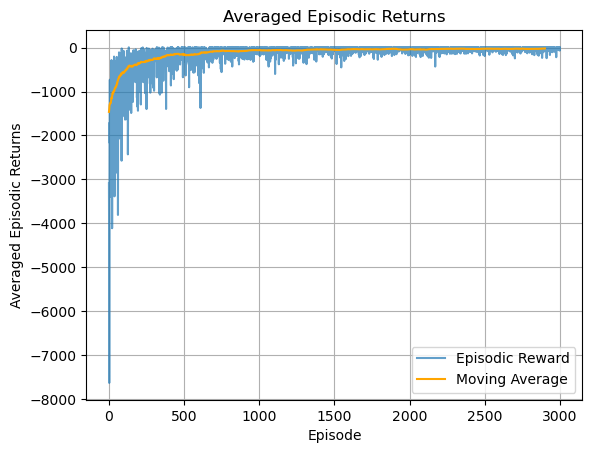

[0 4 4 4 0 0 0 2 0 0 0 0 2 6 0 0 5 0 0 0 0 3 3 3 0 0 0 0 0 0 0 3 0 0 0 0 6
 0 3 0 0 0 0 0 2 0 2 2 0 0 0 0 0 2 2 0 0 3 0 0 0 0 0 0 2 0 2 2 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 3 0 4 0 4 4 3 0 0 3 0 7 3 0 0 5 0 0 0 1 1 1 2 0 2 2 0 0 0
 0 0 0 0 0 1 2 0 2 0 3 3 3 0 0 0 0 0 0 0 3 0 0 0 0 1 0 3 0 0 0 0 0 2 0 2 2
 0 0 0 0 0 2 2 0 0 0 0 2 0 0 0 3 1 0 2 2 0 0 0 0 0 0 0 0 0 2 0 0 0 3 3 3 1
 0 1 1 3 3 0 3 0 3 0 0 3 1 3 0 0 1 1 1 2 0 2 2 0 0 0 0 2 2 2 0 1 2 0 2 0 3
 3 3 2 0 2 2 3 3 0 3 2 2 2 0 3 2 3 2 0 3 3 3 1 0 2 2 3 3 0 3 2 2 2 0 3 2 3
 2 0 3 3 3 2 0 1 1 3 3 0 3 0 0 0 0 3 2 3 0 0 3 3 3 1 0 1 1 3 3 0 3 3 3 3 0
 3 1 3 3 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 2 1 1 0 1 2
 2 1 0 1 2 1 1 0 3 1 1 1 0 1 1 3 1 0 3 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 0 1 0 0 0 0 1 1 1 0 0 1 3 1 1 0 1 1 1 1 0 1 3 3 3 0 3 1 3 1 0 1 1 1 1 0 1
 1 4 4 0 4 1 1 1 0 1 1 5 1 0 1 1 1 1 0 9 2 1 1 0 1 2 2 1 0 6 1 7 8 0 1 1 3
 1 0 1 1 3 1 0 1 1 1 1 0 7 7 7 0 0 1 1 1 9 0 1 1 1 1 0 1 4 4 4 0 1 1 1 5 0
 1 3 1 1 0 1 1 3 2 0 0 3 

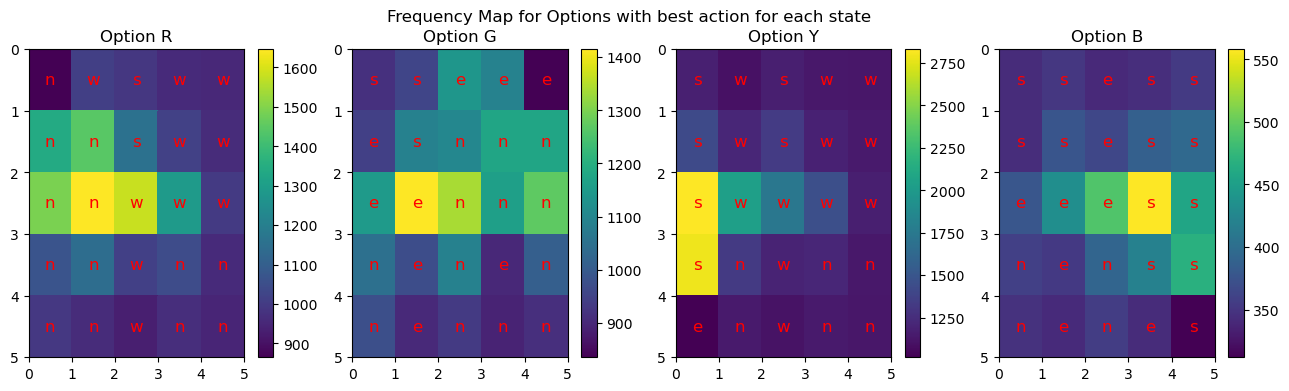

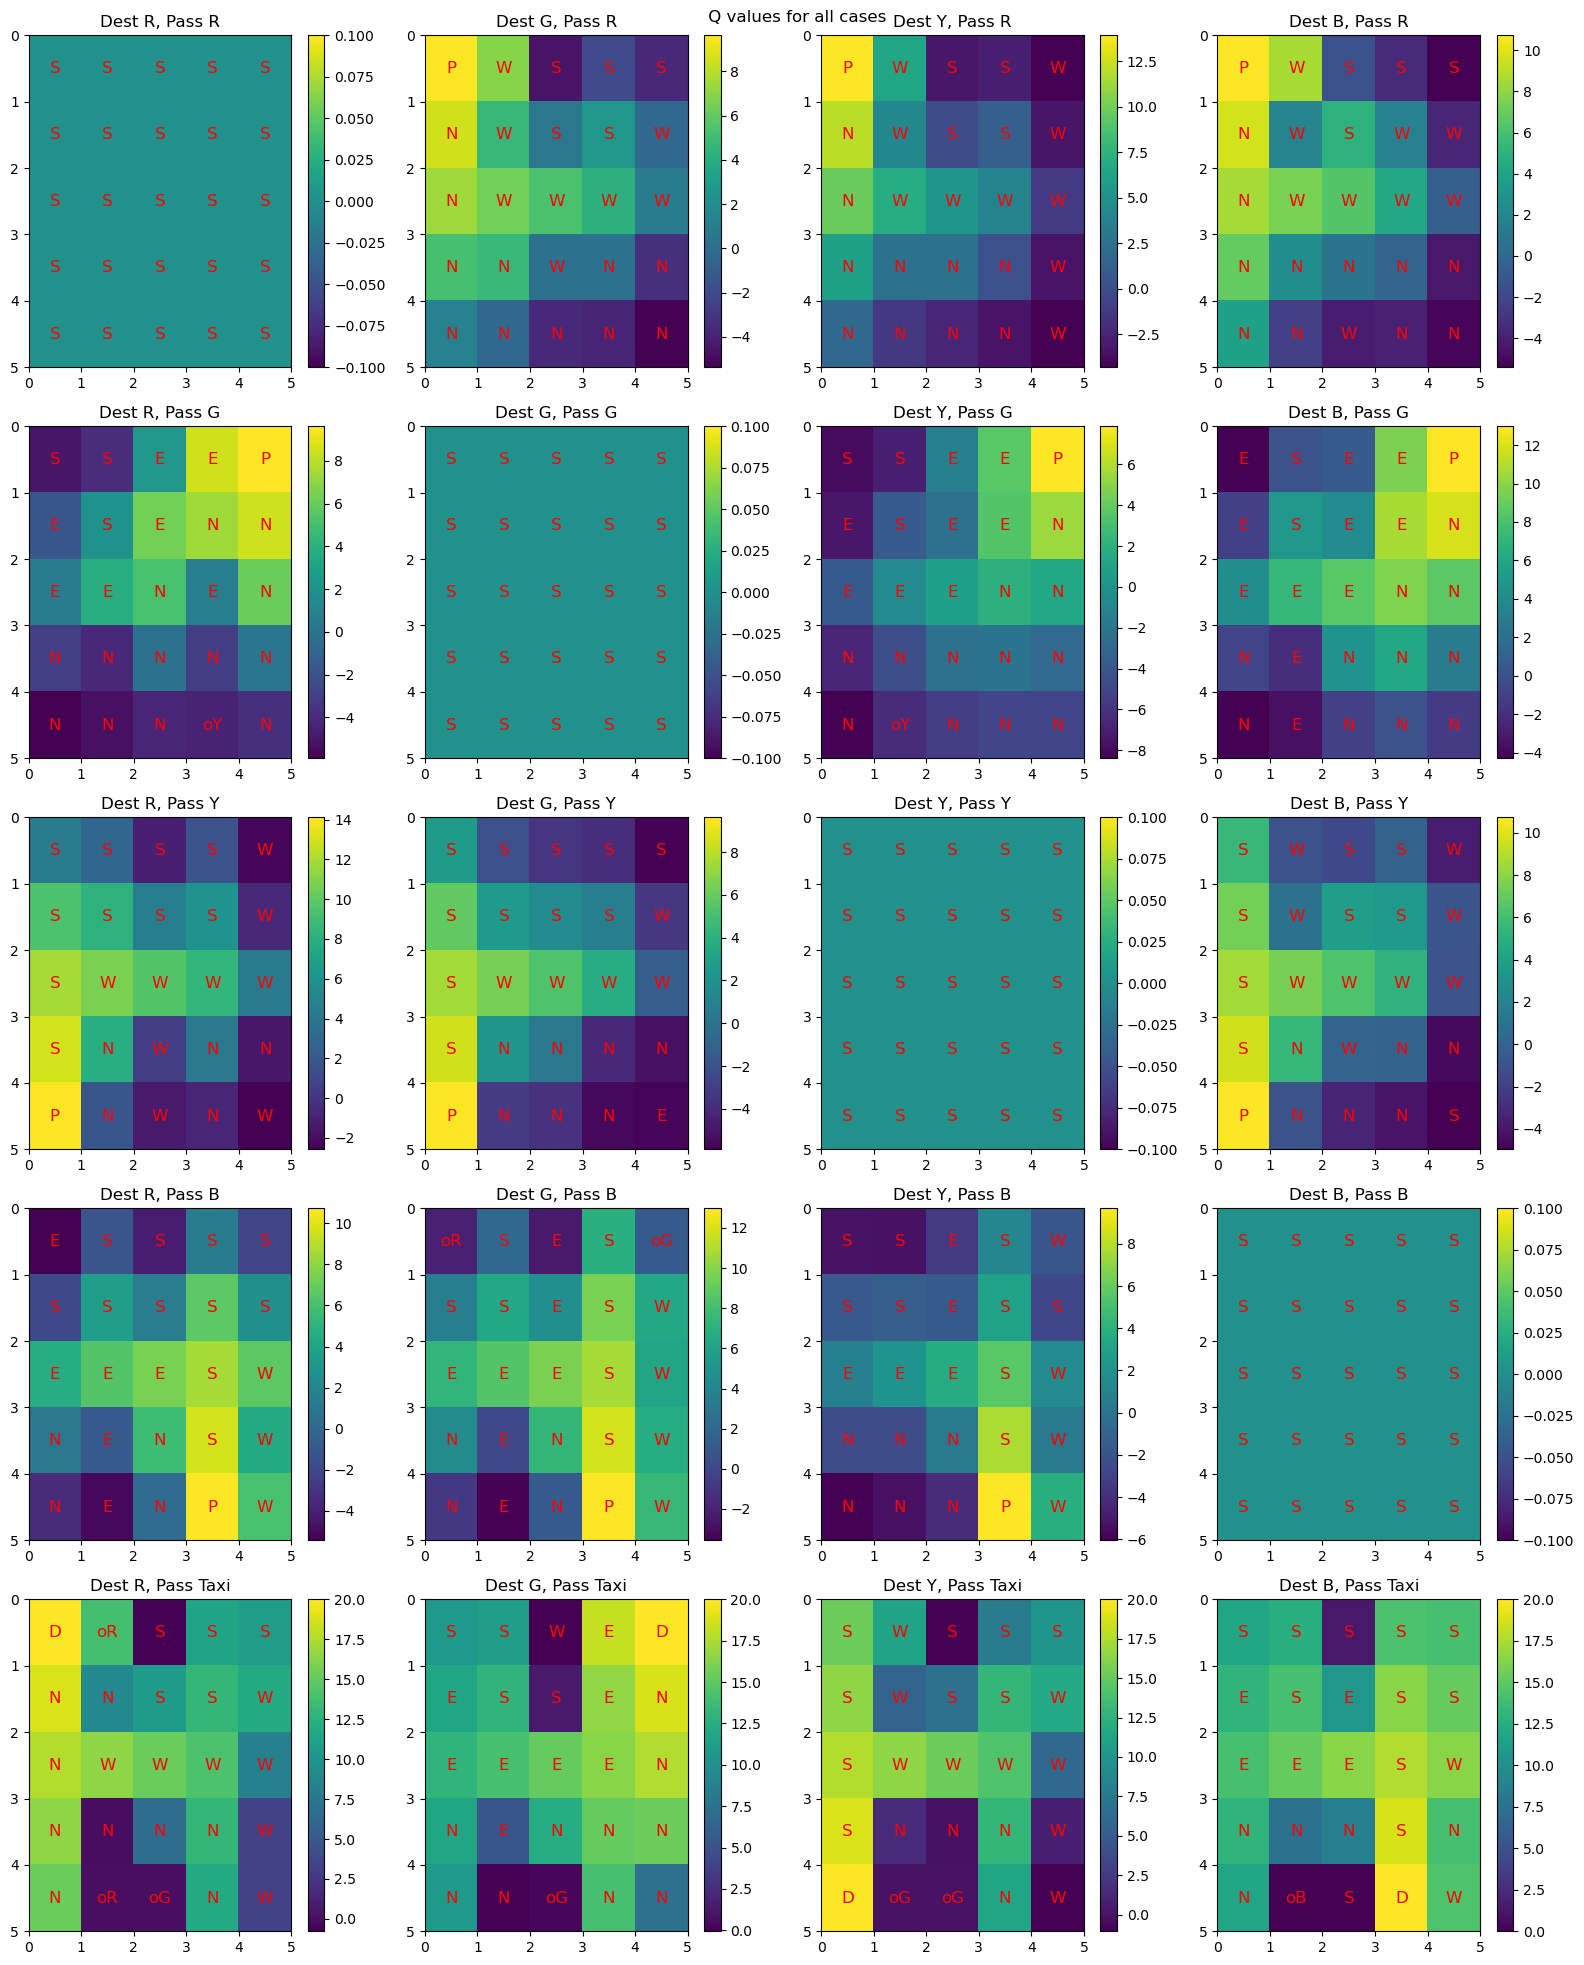

In [123]:
q = np.zeros((500,10))
qf = np.zeros((500,10))
Q_opt = np.zeros((4,25,4))
qof = np.zeros((4,25,4))

smdp = SMDP(q,qf,Q_opt,qof)
smdp.reset()
q = smdp.Qlearn(psuedo=False)
smdp.plot()
#smdp.plot_Qsmdp()
smdp.plot_Q_options()
q_max = np.argmax(q, axis=1)
print(q_max)
smdp.plot_SMDP()

#### SMDP : Learning Options with Psuedo-Reward

In [124]:
EPS = 10000
MAX_STEPS = 500
EXP = 1
ALPHA1 = 0.1
ALPHA2 = 0.05
GAMMA = 0.99
exploration_rate = 1.0
MIN_EXP = 0.01
EXP_DECAY = 0.01

100%|██████████| 3000/3000 [00:04<00:00, 651.90it/s] 


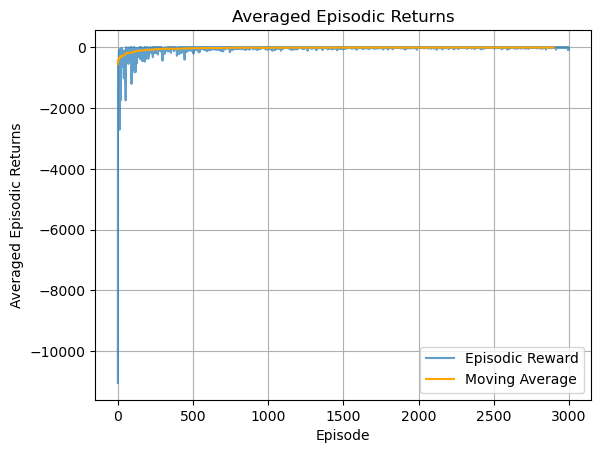

[0 4 4 4 0 0 0 2 0 8 0 0 2 0 0 0 5 0 8 9 0 3 3 3 0 0 0 7 0 0 0 0 0 0 0 0 6
 0 6 3 0 0 0 0 2 0 2 2 0 0 0 0 2 9 0 0 2 0 2 8 0 0 0 0 2 0 2 2 0 0 0 7 0 9
 9 0 0 2 8 2 0 7 6 7 4 0 4 4 2 7 0 3 0 7 7 0 3 5 3 9 0 1 1 1 0 0 2 7 0 0 0
 0 2 2 2 0 1 2 8 0 0 3 3 6 0 0 0 0 3 0 0 0 0 9 0 0 6 0 8 6 0 0 0 0 2 0 2 2
 0 0 0 0 0 9 0 0 2 7 2 8 0 0 0 0 2 0 2 1 0 0 0 0 0 0 0 0 6 7 8 0 0 3 3 3 1
 0 1 1 3 0 0 3 3 3 0 0 3 1 1 9 0 6 6 6 2 0 2 2 8 0 0 8 2 2 2 0 1 2 7 9 0 3
 6 1 2 0 2 7 3 8 0 8 2 2 2 0 0 7 3 8 0 3 6 3 2 0 2 1 8 3 0 3 2 2 2 0 1 1 2
 2 0 3 3 3 2 0 2 1 8 3 0 3 0 0 0 0 6 2 5 9 0 3 3 3 1 0 1 1 3 3 0 3 3 3 3 0
 6 1 1 3 0 1 6 6 1 0 1 7 0 0 0 0 1 9 1 0 0 1 8 1 0 1 1 6 2 0 1 2 1 1 0 1 1
 9 1 0 0 1 2 9 0 1 1 1 1 0 1 7 1 1 0 1 1 1 1 0 0 7 0 4 0 1 1 1 1 0 1 1 1 1
 0 1 0 0 0 0 2 0 0 0 0 3 3 0 1 0 1 1 3 3 0 3 3 0 3 0 6 1 5 9 0 1 1 1 1 0 1
 1 4 4 0 4 1 1 1 0 6 1 5 1 0 1 6 1 0 0 0 7 8 8 0 1 2 2 1 0 0 7 8 3 0 1 1 1
 0 0 1 1 1 0 0 7 1 9 1 0 0 5 0 0 0 9 9 2 7 0 1 2 1 9 0 8 4 4 4 0 6 7 8 5 0
 0 9 2 1 0 1 7 2 1 0 0 3 

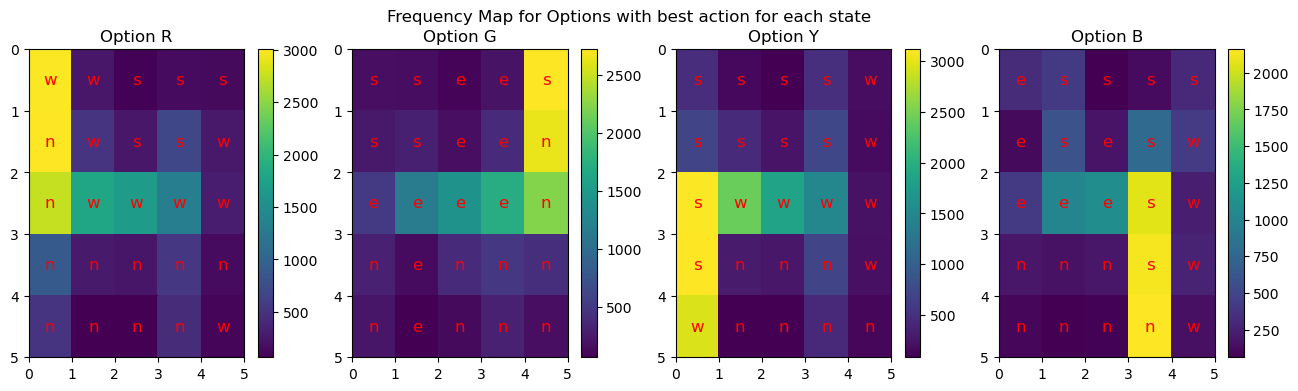

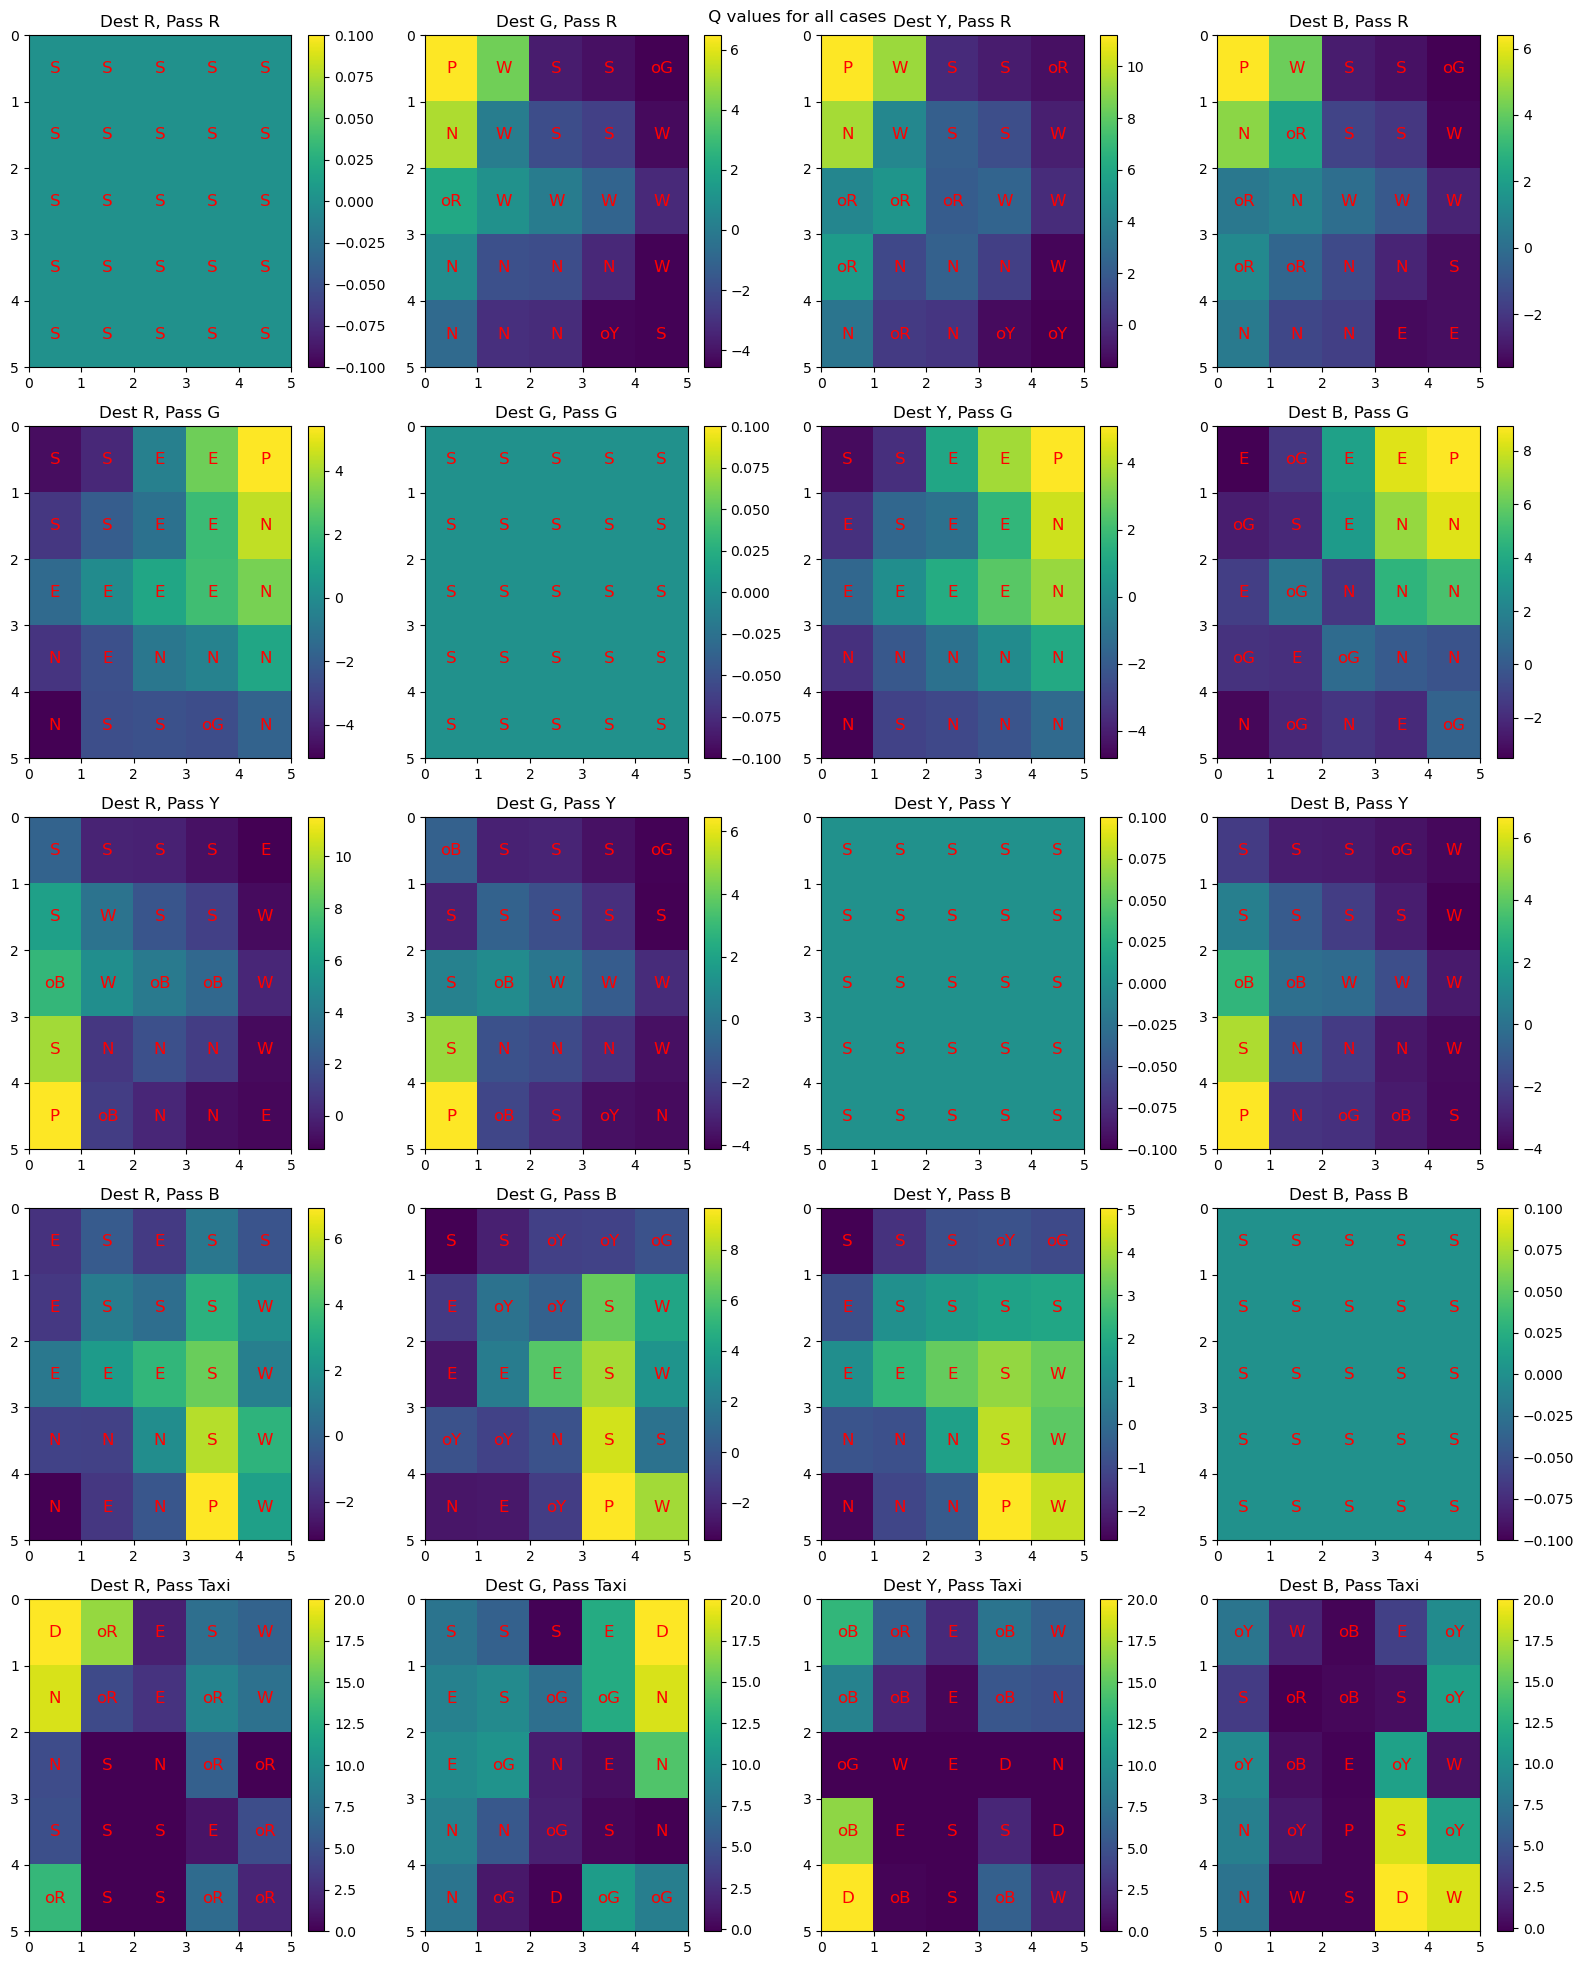

In [125]:
q = np.zeros((500,10))
qf = np.zeros((500,10))
Q_opt = np.zeros((4,25,4))
qof = np.zeros((4,25,4))

smdp = SMDP(q,qf,Q_opt,qof)
smdp.reset()
q = smdp.Qlearn(psuedo=True)
smdp.plot()
smdp.plot_Q_options()
q_max = np.argmax(q, axis=1)
print(q_max)
smdp.plot_SMDP()

#### SMDP : Using Fixed options

In [132]:
EPS = 10000
MAX_STEPS = 500
EXP = 1
ALPHA1 = 0.1
ALPHA2 = 0.05
GAMMA = 0.99
exploration_rate = 1.0
MIN_EXP = 0.01
EXP_DECAY = 0.01

100%|██████████| 3000/3000 [00:26<00:00, 113.14it/s] 


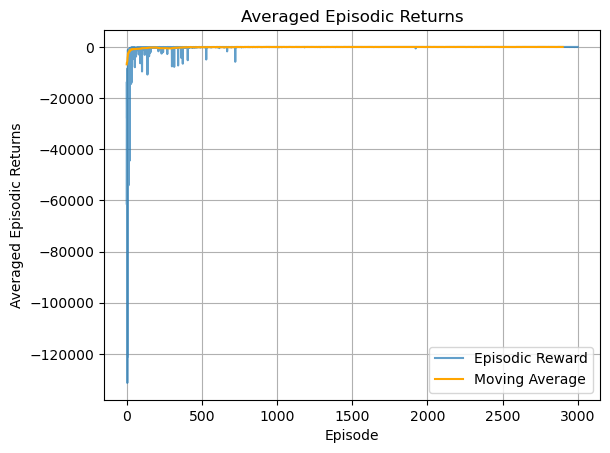

[0 4 4 4 1 0 0 2 0 6 0 0 6 1 6 0 5 0 0 0 0 3 3 3 0 0 0 0 6 0 0 0 0 0 0 0 3
 0 3 0 0 0 0 0 2 0 2 2 0 0 0 0 0 0 0 0 0 2 0 1 0 0 3 0 2 0 2 2 0 0 0 0 0 0
 0 0 0 6 0 0 0 6 3 6 4 0 4 4 3 6 0 3 6 3 6 0 6 5 3 0 0 1 1 1 2 0 2 0 0 0 0
 0 0 2 0 0 1 0 0 0 0 3 3 1 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 2 0 2 2
 0 0 0 0 0 0 0 0 0 2 0 0 0 3 0 3 1 0 2 1 0 0 0 3 0 0 0 0 0 0 0 0 0 3 3 3 1
 0 1 1 3 3 0 3 3 0 0 0 3 1 0 3 0 1 1 1 2 0 2 2 0 0 0 0 2 2 2 0 1 2 0 2 0 1
 1 3 2 0 2 2 3 3 0 3 2 2 2 0 3 2 3 2 0 3 3 3 1 0 2 2 3 3 0 3 2 2 2 0 3 2 3
 2 0 3 3 3 1 0 1 1 3 3 0 3 0 0 0 0 3 2 3 0 0 3 3 3 1 0 1 1 3 3 0 3 3 3 3 0
 3 1 3 3 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1
 1 2 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 3 1 1 1 0 1 1 1 1 0 1 1 1 1
 0 1 0 0 0 0 1 1 1 0 0 3 1 3 1 0 1 1 1 1 0 3 1 3 3 0 3 1 1 3 0 1 1 1 1 0 6
 1 4 4 0 4 1 1 1 0 1 1 5 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 2 0 3 1 1
 1 0 1 1 3 3 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 4 4 4 0 1 1 1 5 0
 2 1 3 1 0 1 1 1 1 0 3 3 

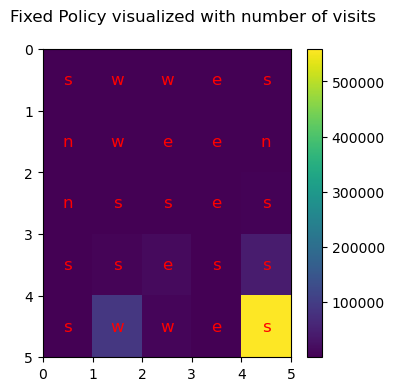

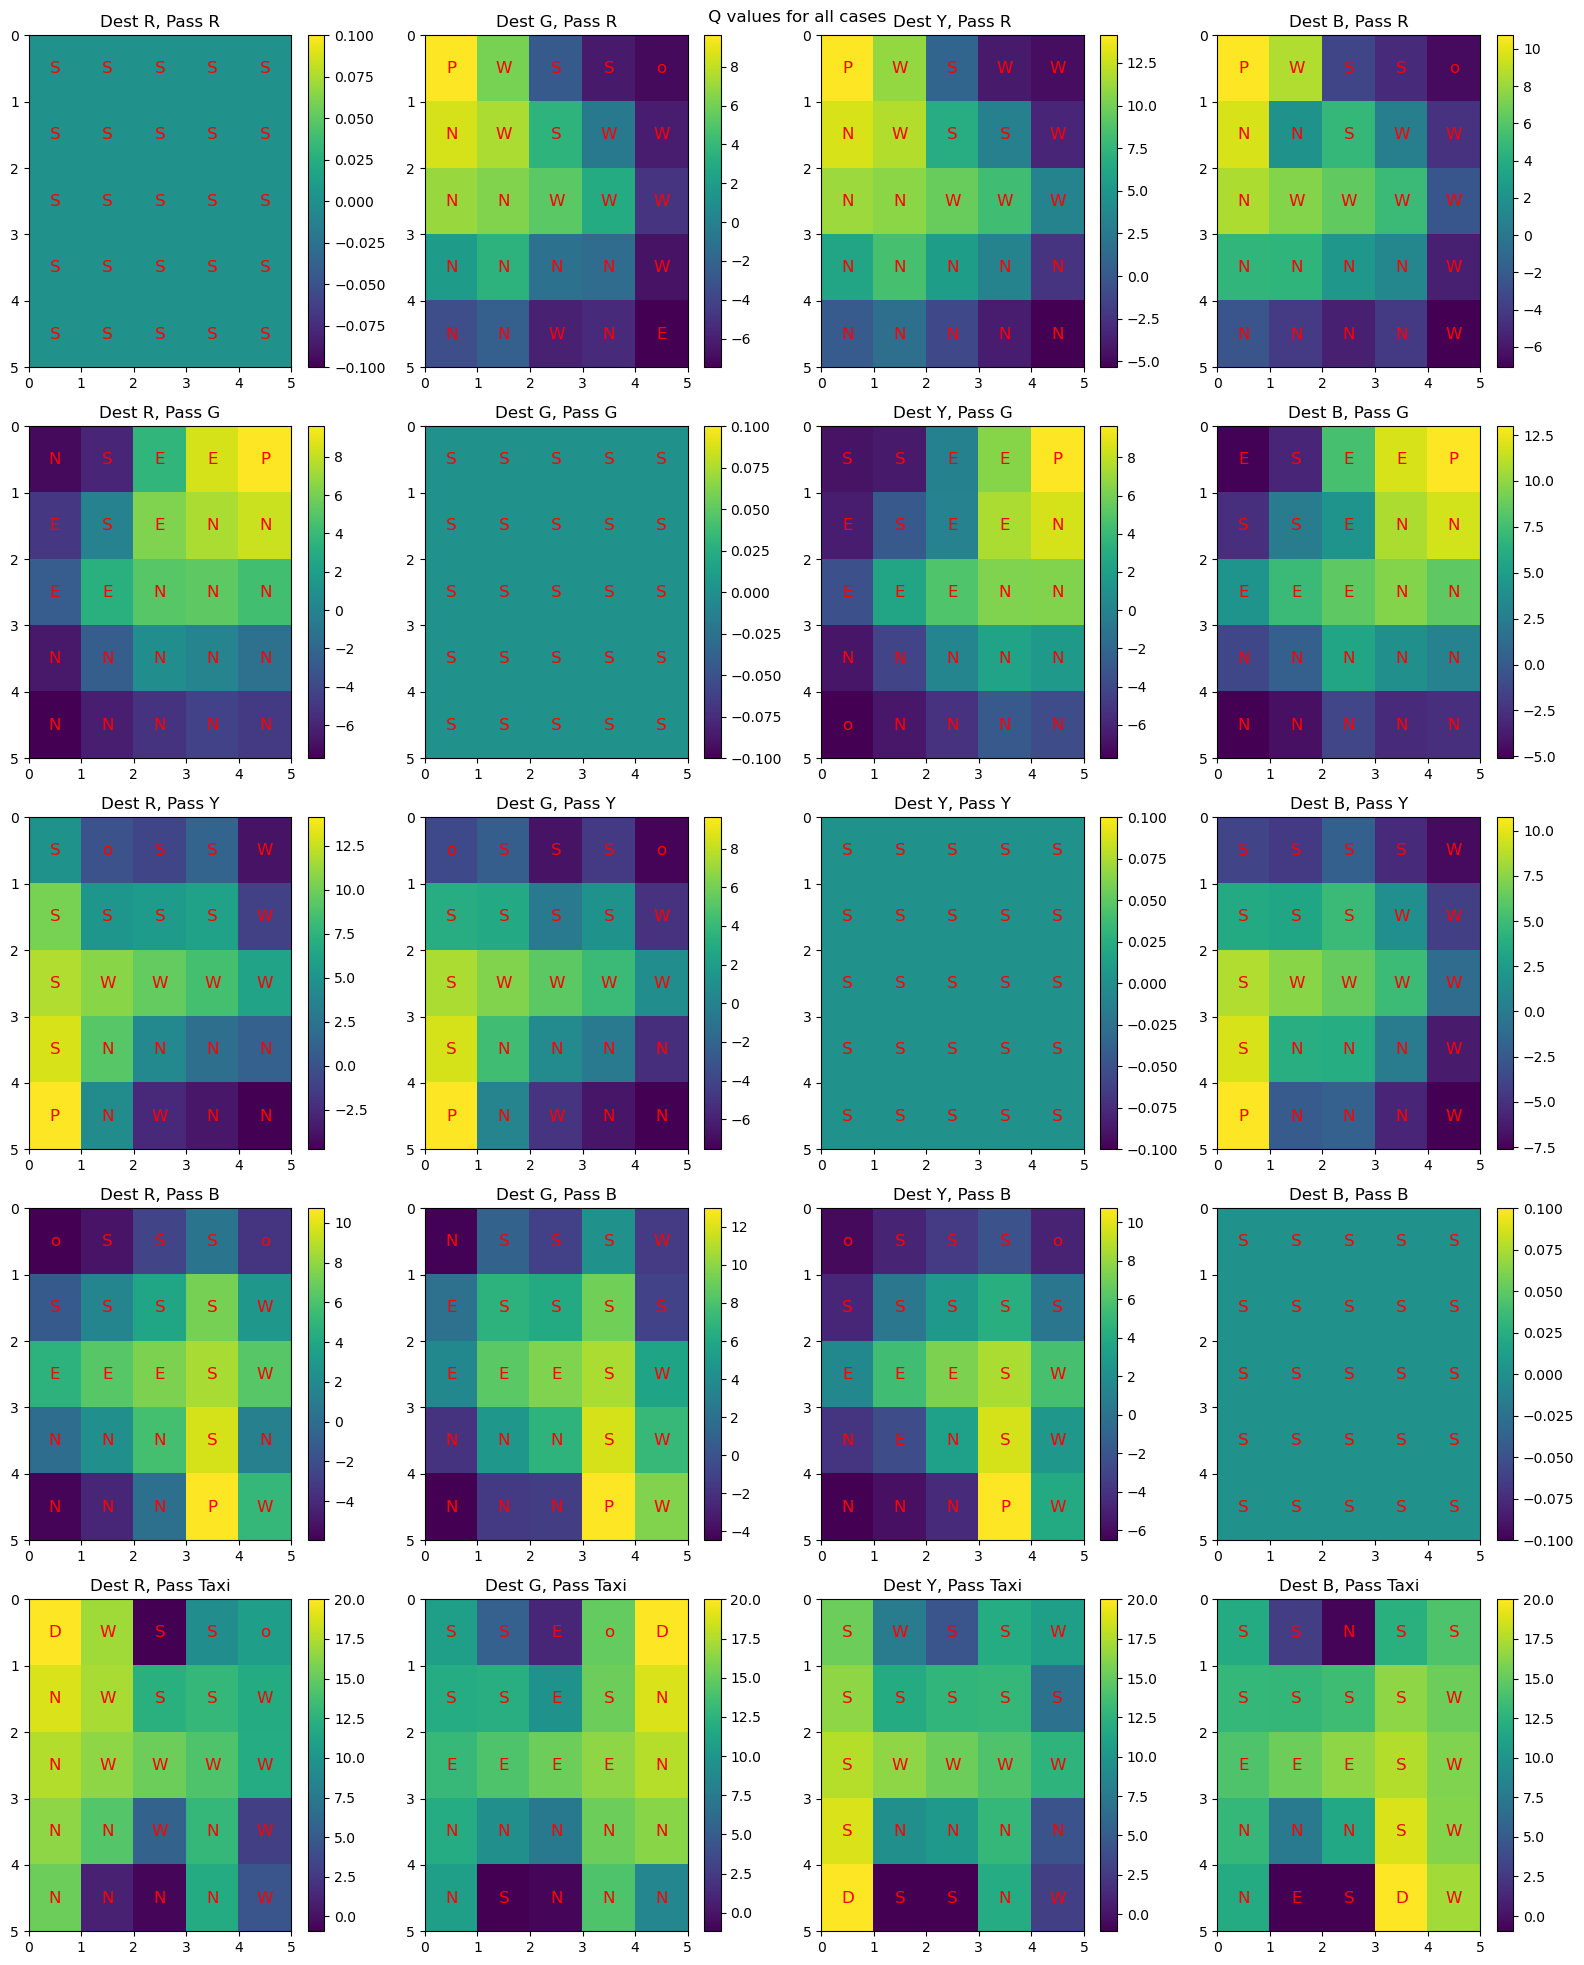

In [134]:
q_custom = np.zeros((500,7))
qf_custom = np.zeros((500,7))
Qof_custom = np.zeros((25,1))

action_map = np.array([[0,3,3,2,0],
                        [1,3,2,2,1],
                        [1,0,0,2,0],
                        [0,0,2,0,0],
                        [0,3,3,2,0]
                        ])

Q_opt_custom = np.zeros((25, 4))
for i in range(5):
    for j in range(5):
        state_num = encode([i, j])  # Get the state number
        value = action_map[i, j]  # Get the value at the current grid cell
        # Update the corresponding subarray in the 25x4 array
        Q_opt_custom[state_num] = np.zeros(4)
        Q_opt_custom[state_num][value] = 1

smdp = SMDP(q_custom,qf_custom,Q_opt_custom,Qof_custom)
smdp.reset()

q = smdp.Qlearn_fixed(psuedo=True)
smdp.plot()
smdp.plot_fixed_option()
q_max = np.argmax(q, axis=1)
print(q_max)
smdp.plot_SMDP(mode="fixed")


### INTRA OPTION

In [128]:
EPS = 10000
MAX_STEPS = 500
EXP = 1
ALPHA1 = 0.1
ALPHA2 = 0.05
GAMMA = 0.99
exploration_rate = 1.0
MIN_EXP = 0.01
EXP_DECAY = 0.01

100%|██████████| 3000/3000 [00:11<00:00, 268.71it/s]


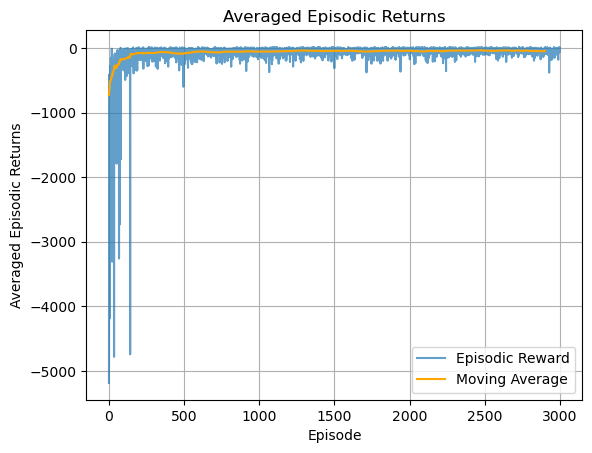

[0 4 4 4 2 0 0 2 0 0 0 0 3 0 0 0 5 2 0 0 0 3 3 3 7 0 0 3 8 8 0 0 9 0 9 0 3
 7 3 3 0 6 0 6 2 0 0 2 8 2 0 0 0 9 2 0 7 7 6 1 0 0 3 0 2 0 2 2 3 8 0 8 0 3
 0 0 0 3 2 0 0 3 3 0 4 0 4 4 0 0 0 3 9 3 3 0 3 5 8 0 0 1 1 1 1 0 2 2 0 0 0
 4 0 0 9 0 1 7 0 2 0 1 1 3 1 0 0 1 0 1 0 0 9 9 0 0 1 1 3 0 0 3 6 1 7 0 2 7
 0 8 0 8 9 0 1 0 2 1 2 0 0 3 3 6 1 0 2 7 3 0 0 3 0 0 0 0 0 7 1 0 0 3 3 6 1
 0 1 1 8 1 0 8 3 3 3 0 3 1 7 0 0 1 1 1 7 0 3 7 0 0 0 0 0 9 9 0 1 0 0 2 0 2
 0 3 1 0 2 7 8 3 0 2 1 9 9 0 2 7 3 2 0 6 6 0 1 0 1 2 3 8 0 8 9 2 1 0 2 7 2
 2 0 3 6 1 3 0 7 1 3 0 0 3 0 0 0 0 6 3 8 2 0 2 3 0 0 0 1 3 0 1 0 8 3 9 0 0
 6 1 3 0 0 1 0 1 2 0 1 1 0 0 0 0 2 9 0 0 1 0 0 1 0 6 2 2 7 0 1 7 1 2 0 2 0
 9 0 0 1 0 8 1 0 6 1 6 1 0 7 7 8 8 0 8 0 0 1 0 0 2 0 1 0 1 1 0 2 0 7 1 2 0
 0 1 0 0 0 0 1 0 2 2 0 6 1 6 7 0 3 7 8 3 0 0 0 0 3 0 3 0 1 0 0 1 6 6 1 0 7
 1 4 4 0 4 1 9 1 0 1 5 5 1 0 6 1 6 3 0 7 7 8 1 0 0 0 2 0 0 0 0 0 0 0 1 1 1
 1 0 1 1 8 1 0 1 9 9 9 0 0 2 0 1 0 1 2 6 2 0 9 7 2 2 0 8 4 4 4 0 1 0 0 5 0
 3 1 3 2 0 7 7 0 0 0 8 3 

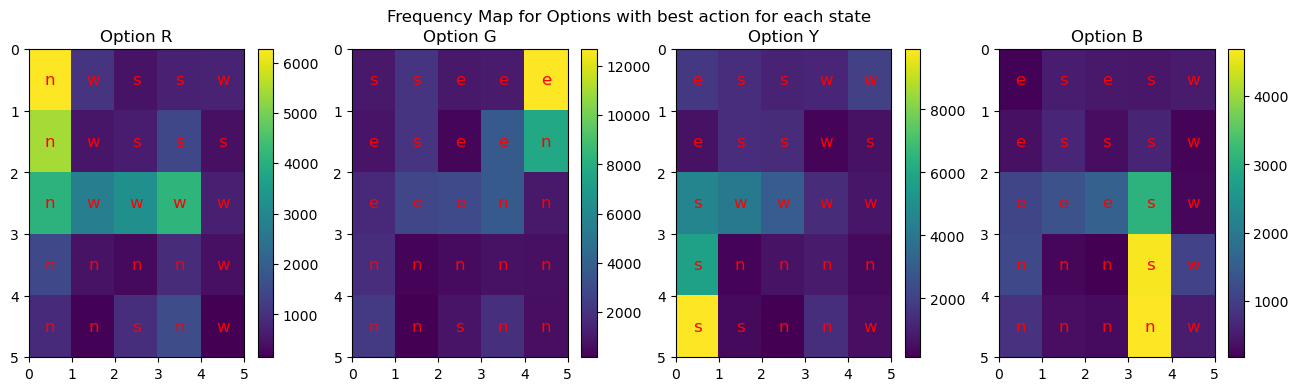

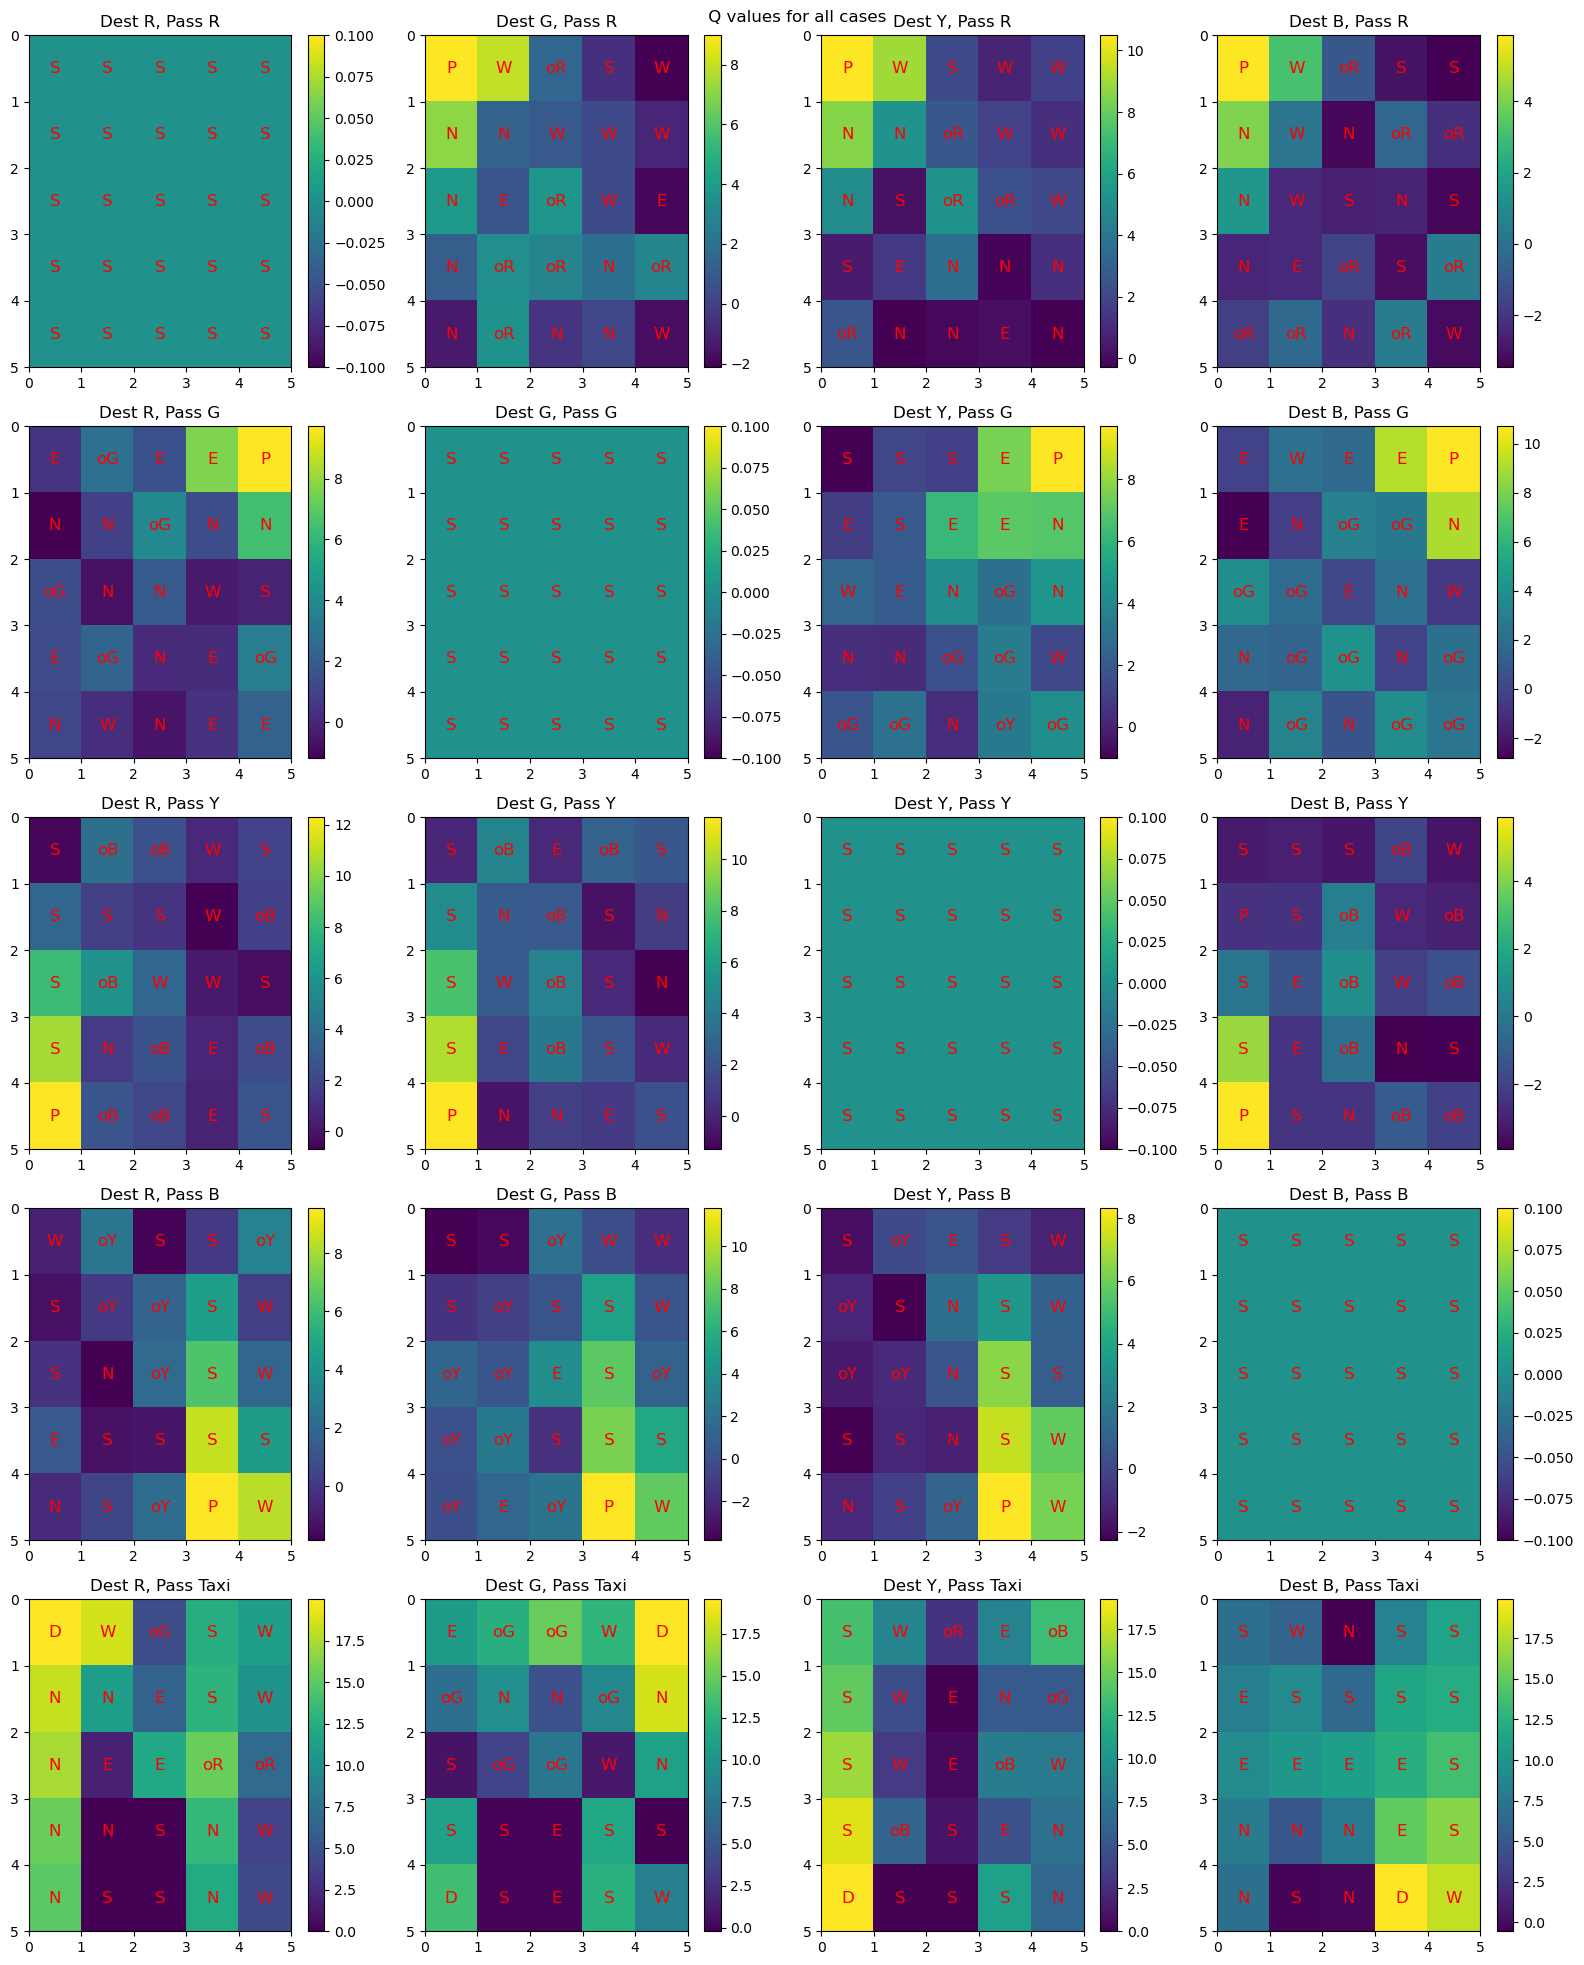

In [129]:
q = np.zeros((500,10))
qf = np.zeros((500,10))
Q_opt = np.zeros((4,25,4))
qof = np.zeros((4,25,4))

smdp = SMDP(q,qf,Q_opt,qof)
smdp.reset()
q = smdp.Qlearn_intra(psuedo=True)
smdp.plot()
smdp.plot_Q_options()
q_max = np.argmax(q, axis=1)
print(q_max)
smdp.plot_SMDP()